In [1]:
#!/usr/bin/python
# updated DBR 02/2023 #

%matplotlib inline

import numpy as np
import scipy.optimize as opt
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

#for mixed effects models
import statsmodels.api as sm
import statsmodels.formula.api as smf

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

#my power law fitter, for smaller sample sizes
import ra_module

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [2]:
#functions for distribution fitting

#ecology calculations from resampled list of abundances

def calc_ecol(rs):
    l=rs[rs>0] #just keep nonzero
    R=len(l);  
    r=np.arange(R)+1
    a=-np.sort(-l)
    N=np.sum(a)
    pars=a/N
    cpa=np.cumsum(pars)
    
    D1=np.exp(-np.sum(pars*np.log(pars))) 
    D2=1/np.sum(pars**2)
    
    maxclone=a[0]/N
    
    top10clones=np.sum(a[:10])/N
    
    clonalf=np.sum(a[a>1])/N
    
    return r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf

#single power law
def pwl1(xx):
    al1=xx
    model_pa= r**-al1
    return model_pa/np.sum(model_pa)

#2 phase power law
def pwl2(xx):    
    al1,al2,psi=xx
    model_pa= r**-al1 + 1/psi*r**-al2
    return model_pa/np.sum(model_pa)
        
#calculate error for distribution, species abundance distribution
def SAD_error(xx):
    
    if dist_name=='pwl1':
        model_pa=pwl1(xx)
        
    if dist_name=='pwl2':
        model_pa=pwl2(xx)
           
    RMS = np.sqrt(np.mean((cpa[:maxr]-np.cumsum(model_pa[:maxr]))**2))
    #KS = np.max(cpa[:maxr]-np.cumsum(model_pa[:maxr]))
    #error=RMS
    return RMS



In [16]:

#simulate a single powerlaw distribution with variable alphas and calculate metrics and fit power laws

Rtrue=1e6

simalphas = [0.3,0.8,1.2]

siml=[]
for ia,alsim in enumerate(simalphas):
    r=np.arange(Rtrue)+1
    pa=r**-alsim/np.sum(r**-alsim)

    outl=[]
    for ss in [50,100,500,1000,5000,10000]:
        rs = np.random.multinomial(n=ss,pvals=pa) #resampled abundance

        out=calc_ecol(rs) #ecology metrics, just using normal abundance

        r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=out #metrics

        maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed
        #maxr=len(a)#[a>2]) #fit to non singletons? or shoudl this be a fixed

        dist_name='pwl1'
        result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                               bounds=[[0.01,2.]], method='L-BFGS-B')
        dist_name='pwl2'
        result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                               bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')

        fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=a,R=10**6,max_al=2)
        best_al=fit_al[np.argmin(fit_score[0])]

        outl.append([alsim,ss,Rtrue,R/ss,D1/ss,D2/ss,best_al,result1.x])

    simdf=pd.DataFrame(outl,columns=['alsim','samplesize','Rtrue','RN','D1N','D2N','alsample','alfit'])
    siml.append(simdf)
    


/Applications/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


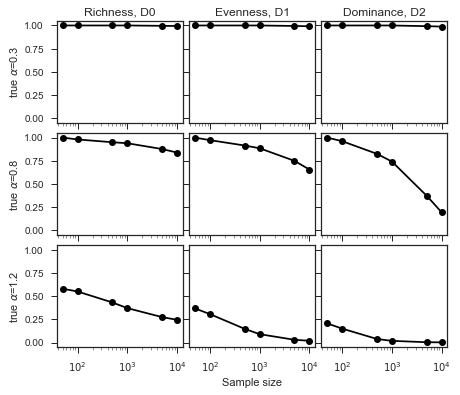

In [17]:
#first show sensitivity of ecological metrics
fig,axs=plt.subplots(3,3,sharex=True,sharey=True,figsize=(7,6))

for ia,alsim in enumerate(simalphas):

    simdf=siml[ia]
    axs[ia][0].semilogx(simdf['samplesize'],simdf['RN'],marker='o',color='k')
    axs[ia][1].semilogx(simdf['samplesize'],simdf['D1N'],marker='o',color='k')
    axs[ia][2].semilogx(simdf['samplesize'],simdf['D2N'],marker='o',color='k',label=alsim)
    
axs[2][1].set_xlabel('Sample size')
 
axs[0][0].set_title('Richness, D0')
axs[0][1].set_title('Evenness, D1')
axs[0][2].set_title('Dominance, D2')

for ii in range(3):
    axs[ii][0].set_ylabel(r'true $\alpha$='+str(simalphas[ii]))

plt.subplots_adjust(wspace=0.05,hspace=0.1)
plt.savefig('figures/S3_metrics-vs-N.pdf',dpi=300)



In [ ]:
#now show variability of resample?

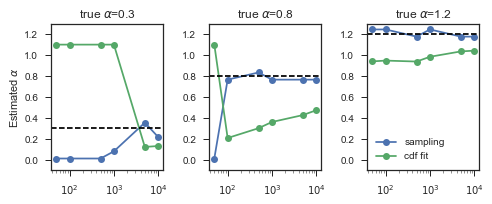

In [20]:
#show fitting algorithm works

plt.figure(figsize=(7,3))
for ia,alsim in enumerate(simalphas):
    plt.subplot(131+ia)
    simdf=siml[ia]
    plt.plot(simdf['samplesize'],simdf['alsample'],label='sampling',marker='o')
    plt.semilogx(simdf['samplesize'],simdf['alfit'],label='cdf fit',marker='o')
    plt.axhline(alsim,color='k',ls='--')
    plt.ylim([-0.1,1.3])
    plt.title(r'true $\alpha$='+str(alsim))

    if ia==0:
        plt.ylabel(r'Estimated $\alpha$')
plt.legend()

plt.tight_layout()

In [29]:
#simulate a double powerlaw distribution to check on fitting with sample vs lsq fit

Rtrue=1e6

al2sim=0.4
phi=1/40

simalphas=[0.9,1.2,1.5]
siml2=[]
for al1sim in simalphas:
    r=np.arange(Rtrue)+1
    pa=r**-al1sim + phi*r**-al2sim
    pa=pa/np.sum(pa)

    outl=[]
    for ss in [10,50,100,500,1000,5000,10000]:
        rs = np.random.multinomial(n=ss,pvals=pa) #resampled abundance

        out=calc_ecol(rs) #ecology metrics, just using normal abundance

        r,a,pars,cpa,R,D1,D2,maxclone,top10clones,clonalf=out #metrics

        maxr=len(a[a>1]) #fit to non singletons? or shoudl this be a fixed

        dist_name='pwl1'
        result1 = opt.minimize(SAD_error,x0=[1.1],tol=1e-15, 
                               bounds=[[0.01,2.]], method='L-BFGS-B')
        dist_name='pwl2'
        result2 = opt.minimize(SAD_error,x0=[1.1,0.3,10.],tol=1e-15, 
                               bounds=[[0.001,100.],[0.001,3.],[1.,100]], method='L-BFGS-B')

        fit_al,fit_score,ll=ra_module.fit_pwl1(num_fits=30,num_replicates=3,dat_abund=a,R=10**6,max_al=2)
        best_al=fit_al[np.argmin(fit_score[0])]

        outl.append([alsim,ss,Rtrue,R/ss,D1/ss,D2/ss,best_al,result2.x[0],result2.x[1],result2.x[2]])

    simdf=pd.DataFrame(outl,columns=['alsim','samplesize','Rtrue','RN','D1N','D2N','alsample','al1fit','al2fit','phifit'])
    siml2.append(simdf)
    


/Applications/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


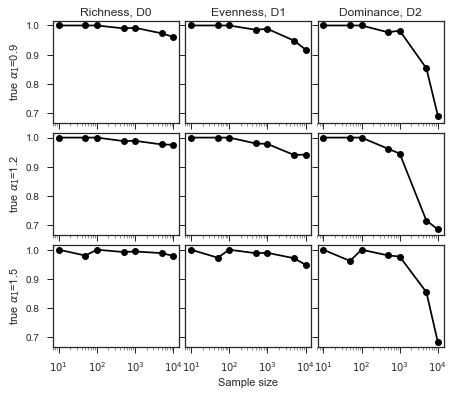

In [30]:
#first show sensitivity of ecological metrics
fig,axs=plt.subplots(3,3,sharex=True,sharey=True,figsize=(7,6))

for ia,alsim in enumerate(simalphas):

    simdf=siml2[ia]
    axs[ia][0].semilogx(simdf['samplesize'],simdf['RN'],marker='o',color='k')
    axs[ia][1].semilogx(simdf['samplesize'],simdf['D1N'],marker='o',color='k')
    axs[ia][2].semilogx(simdf['samplesize'],simdf['D2N'],marker='o',color='k',label=alsim)
    
axs[2][1].set_xlabel('Sample size')
 
axs[0][0].set_title('Richness, D0')
axs[0][1].set_title('Evenness, D1')
axs[0][2].set_title('Dominance, D2')

for ii in range(3):
    axs[ii][0].set_ylabel(r'true $\alpha_1$='+str(simalphas[ii]))

plt.subplots_adjust(wspace=0.05,hspace=0.1)
plt.savefig('figures/S3_metrics-vs-N-doublepwl.pdf',dpi=300)



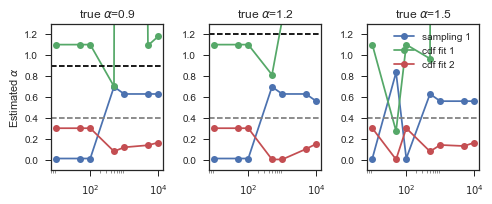

In [31]:
#show fitting algorithm works

plt.figure(figsize=(7,3))
for ia,alsim in enumerate(simalphas):
    plt.subplot(131+ia)
    simdf=siml2[ia]
    plt.plot(simdf['samplesize'],simdf['alsample'],label='sampling 1',marker='o')
    plt.semilogx(simdf['samplesize'],simdf['al1fit'],label='cdf fit 1',marker='o')
    plt.semilogx(simdf['samplesize'],simdf['al2fit'],label='cdf fit 2',marker='o')
    plt.axhline(alsim,color='k',ls='--')
    plt.axhline(0.4,color='gray',ls='--')
    plt.ylim([-0.1,1.3])
    plt.title(r'true $\alpha$='+str(alsim))

    if ia==0:
        plt.ylabel(r'Estimated $\alpha$')
plt.legend()

plt.tight_layout()

In [25]:
result2.x[1]

0.001

In [ ]:
#cabotegravir is 4000 per dose, annual 30k! sunleca (lenacapavir) is 40k per year!

#relative cost effectiveness of cabotegravir lancet?

#step one, approach women at risk, counsel for PreP
#if they DON'T want PrEP offered AMP2 study enrollment
#offer prep during AMP2, women can opt out of AMP and continue prep